# HSE 2024: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 10 days for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand.

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [ ]:
def H(y):
    """
    Calculate impurity criterion using mean absolute deviation

    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measured by mean absolute deviation)
    """
    if len(y) == 0:
        return 0.0
    return np.mean(np.abs(y - np.mean(y)))



In [ ]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote:
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [ ]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node
    y : ndarray
        array of target values in the node
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """
    # Split data into left and right nodes(based on threshold)
    left_indices = X[:, j] <= t
    right_indices = X[:, j] > t

    R_l = y[left_indices]
    R_r = y[right_indices]

    # sizes of the nodes
    R_size = len(y)
    R_l_size = len(R_l)
    R_r_size = len(R_r)

    # impurity for each node
    H_l = H(R_l)
    H_r = H(R_r)

    # cases where the split is invalid
    if R_size == 0:
        return 0.0

    # the cost function
    Q_value = (R_l_size / R_size) * H_l + (R_r_size / R_size) * H_r

    return Q_value

# the impurity function H as from Task 1
def H(y):
    if len(y) == 0:
        return 0.0
    return np.mean(np.abs(y - np.mean(y)))

# usage and debugging
X_test = np.array([[2.5, 3.1], [1.2, 2.2], [3.3, 1.1], [4.0, 3.3]])
y_test = np.array([1.0, 0.5, 1.5, 1.2])

# and print Q for debugging
print("Q(X_test, y_test, 0, 3.0):", Q(X_test, y_test, 0, 3.0))
print("Q(X_test, y_test, 1, 2.5):", Q(X_test, y_test, 1, 2.5))




Q(X_test, y_test, 0, 3.0): 0.2
Q(X_test, y_test, 1, 2.5): 0.3


### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [ ]:
def fit(self, X, y):
    """
    Fit the Decision Tree Regressor.

    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
        The target values.
    Returns
    -------
    self : object
        Returns self.
    """
    # Validate
    X, y = check_X_y(X, y, accept_sparse=False)

    # number of features
    self.n_features_in_ = X.shape[1]


    self.is_fitted_ = True


    self.tree_ = Node()
    self.tree_.depth = 1
    self.tree_.prediction = np.mean(y)


    self.grow_tree(self.tree_, X, y)
    return self


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


class Node(object):
    """
    Class for a decision tree node.
    """
    def __init__(self):
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None

    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.
    """
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def best_split(self, X, y):
        """
        Finds the best split for a node.
        """
        best_split_column = None
        best_threshold = None
        best_cost = float('inf')

        X_left, y_left, X_right, y_right = None, None, None, None

        for j in range(X.shape[1]):
            # midpoints between unique sorted values
            unique_values = np.sort(np.unique(X[:, j]))
            thresholds = (unique_values[:-1] + unique_values[1:]) / 2

            for t in thresholds:
                left_indices = X[:, j] <= t
                right_indices = X[:, j] > t

                R_l, R_r = y[left_indices], y[right_indices]

                # Skip splits that violate constraints
                if len(R_l) < self.min_samples_leaf or len(R_r) < self.min_samples_leaf:
                    continue

                cost = Q(X, y, j, t)
                if cost < best_cost:
                    best_cost = cost
                    best_split_column = j
                    best_threshold = t
                    X_left, y_left = X[left_indices], y[left_indices]
                    X_right, y_right = X[right_indices], y[right_indices]

        return best_split_column, best_threshold, X_left, y_left, X_right, y_right


    def is_terminal(self, node, y):
        """
        Determines whether a node should be terminal.
        """
        if node.depth >= self.max_depth:
            return True
        if len(y) < self.min_samples_split:
            return True
        return False

    def grow_tree(self, node, X, y):
        """
        Recursively grows the decision tree.
        """
        if self.is_terminal(node, y):
            node.is_terminal = True
            node.prediction = np.mean(y)
            return

        best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)
        if best_split_column is None:
            node.is_terminal = True
            node.prediction = np.mean(y)
            return

        node.column = best_split_column
        node.threshold = best_threshold

        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)

        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_right)

        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)

    def fit(self, X, y):
        """
        Fits the decision tree to the data.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.n_features_in_ = X.shape[1]
        self.is_fitted_ = True

        self.tree_ = Node()
        self.tree_.depth = 1
        self.tree_.prediction = np.mean(y)

        self.grow_tree(self.tree_, X, y)
        return self

    def get_prediction(self, node, x):
        """
        Recursively predicts for a single sample.
        """
        if node.is_terminal:
            return node.prediction

        if x[node.column] <= node.threshold:
            return self.get_prediction(node.left, x)
        else:
            return self.get_prediction(node.right, x)

    def predict(self, X):
        """
        Predicts for an array of samples.
        """
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')

        if hasattr(self, "n_features_in_"):
            if X.shape[1] != self.n_features_in_:
                raise ValueError(
                    f"Number of features in input ({X.shape[1]}) "
                    f"does not match number of features seen during fit ({self.n_features_in_})."
                )

        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)


def H(y):
    """
    Calculates impurity using mean absolute deviation.
    """
    if len(y) == 0:
        return 0.0
    impurity = np.mean(np.abs(y - np.mean(y)))
    print(f"Impurity (H) for y={y}: {impurity}")
    return impurity

def Q(X, y, j, t):
    """
    Calculate the cost function value for a given feature and threshold.
    """
    left_indices = X[:, j] <= t
    right_indices = X[:, j] > t

    R_l = y[left_indices]
    R_r = y[right_indices]

    R_size = len(y)
    R_l_size = len(R_l)
    R_r_size = len(R_r)

    if R_size == 0 or R_l_size == 0 or R_r_size == 0:
        return float('inf')  # Invalid split has infinite cost

    H_l = H(R_l)
    H_r = H(R_r)

    cost = (R_l_size / R_size) * H_l + (R_r_size / R_size) * H_r
    print(f"Cost (Q) for feature {j}, threshold {t}: {cost}, Left: {R_l}, Right: {R_r}")
    return cost



from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())


Streaming output truncated to the last 5000 lines.
 -1.46642433 -0.31932842 -1.38336396 -1.5829384   0.61037938 -1.18885926
 -0.50681635 -0.0525673  -1.93627981 -0.31088617  0.09740017 -2.77259276
 -0.39095338 -0.11610394 -2.03068447  1.02017271  0.28634369  0.60884383
 -1.04525337  1.30184623 -0.62808756  2.3039167   0.09772497  0.58295368
 -0.39944903]
Impurity (H) for y=[ 0.91017891 -0.01702041 -0.955945   -0.34598178 -0.46359597  0.48148147
 -1.54079701  0.06326199  0.15650654 -0.23792173 -1.42406091 -0.49331988
  0.41605005 -1.15618243  0.42625873 -0.63743703 -0.30901297 -0.57578797
  0.14195316 -0.72559738 -0.59631404  0.1887786   0.52389102  0.08842209
  0.39904635  0.39009332 -0.65240858  0.49374178  2.06449286 -0.11054066
 -0.69204985  1.53637705  1.21114529  0.68981816  1.30184623 -0.48102712
 -1.06001582 -0.1359497   1.13689136]: 0.6469599711029171
Impurity (H) for y=[-0.36918184 -0.23937918  0.65526373  0.64013153 -1.61695604 -0.02432612
 -0.73803091  0.2799246  -0.09815039

Streaming output truncated to the last 5000 lines.
 -12.55807389  15.01996766  34.50459018 -12.0363855   15.16204796
  63.55633593 -21.62379263  -9.75232562 -16.26246864 -12.5844933
 -27.0410512   13.82015105   8.71911071 -13.59927355   0.28445223
  -9.9753657   61.96236579 -15.81984182  14.44739156  13.88906421
  -7.66486983  -9.78267718  13.66401013  -9.42488922  40.5063418
 -23.47010643  32.17396589  34.0206566   65.82377487  40.84203409
  10.11000622  12.26778153 -22.80066752   4.70734503   7.06163152
  44.18105707  -4.76523173 -19.59823252  -0.61273226  -5.80021775
  56.74346165   2.89543125 -20.94734406 -19.26324365  77.32381901
  -2.9323316  -12.99357941]: 22.001363388087377
Cost (Q) for feature 0, threshold -0.6610208774555415: 20.70019574559947, Left: [ -44.05770173  -33.88805311  -81.83534115 -109.4378073   -50.05266618
  -37.95939495  -28.28791822  -82.9872729   -46.16215583  -29.34971484
  -61.12293843  -72.06588651  -79.90568355  -58.99326029  -61.75396116
  -50.87199832  

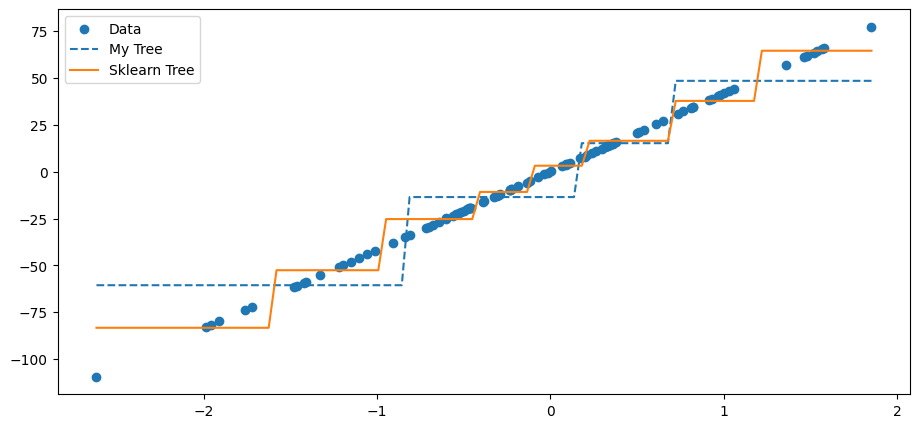

In [ ]:
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor

X, y = make_regression(n_samples=100, n_features=1, noise=0.1, random_state=42)

# Decision Tree Regressor
my_tree = MyDecisionTreeRegressor(max_depth=3, min_samples_split=2, min_samples_leaf=1)
my_tree.fit(X, y)

# Scikit-learn Decision Tree Regressor
sklearn_tree = DecisionTreeRegressor(max_depth=3, random_state=42)
sklearn_tree.fit(X, y)

# Compare predictions
X_test = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
my_predictions = my_tree.predict(X_test)
sklearn_predictions = sklearn_tree.predict(X_test)


plt.scatter(X, y, label='Data')
plt.plot(X_test, my_predictions, label='My Tree', linestyle='--')
plt.plot(X_test, sklearn_predictions, label='Sklearn Tree', linestyle='-')
plt.legend()
plt.show()


In [ ]:
def print_tree(node, depth=0):
    if node.is_terminal:
        print("  " * depth + f"Leaf: Prediction = {node.prediction}")
    else:
        print("  " * depth + f"Split: Feature {node.column}, Threshold {node.threshold}")
        print_tree(node.left, depth + 1)
        print_tree(node.right, depth + 1)
print_tree(my_tree.tree_)


Split: Feature 0, Threshold 0.14114543544991828
  Split: Feature 0, Threshold -0.8238555630579131
    Leaf: Prediction = -60.57673623244481
    Leaf: Prediction = -13.544940462733441
  Split: Feature 0, Threshold 0.6930775590480515
    Leaf: Prediction = 15.207465459026702
    Leaf: Prediction = 48.47847930460548


In [ ]:
from sklearn.tree import export_text

print(export_text(sklearn_tree, feature_names=["Feature 0"]))


|--- Feature 0 <= -0.09
|   |--- Feature 0 <= -0.96
|   |   |--- Feature 0 <= -1.60
|   |   |   |--- value: [-83.30]
|   |   |--- Feature 0 >  -1.60
|   |   |   |--- value: [-52.58]
|   |--- Feature 0 >  -0.96
|   |   |--- Feature 0 <= -0.43
|   |   |   |--- value: [-25.29]
|   |   |--- Feature 0 >  -0.43
|   |   |   |--- value: [-10.80]
|--- Feature 0 >  -0.09
|   |--- Feature 0 <= 0.69
|   |   |--- Feature 0 <= 0.23
|   |   |   |--- value: [3.18]
|   |   |--- Feature 0 >  0.23
|   |   |   |--- value: [16.49]
|   |--- Feature 0 >  0.69
|   |   |--- Feature 0 <= 1.21
|   |   |   |--- value: [37.77]
|   |   |--- Feature 0 >  1.21
|   |   |   |--- value: [64.54]



In [ ]:
for x, y_pred_my, y_pred_sklearn in zip(X_test, my_predictions, sklearn_predictions):
    print(f"Input: {x}, My Tree Prediction: {y_pred_my}, Sklearn Prediction: {y_pred_sklearn}")


Input: [-2.6197451], My Tree Prediction: -60.57673623244481, Sklearn Prediction: -83.29509709694115
Input: [-2.57457315], My Tree Prediction: -60.57673623244481, Sklearn Prediction: -83.29509709694115
Input: [-2.5294012], My Tree Prediction: -60.57673623244481, Sklearn Prediction: -83.29509709694115
Input: [-2.48422925], My Tree Prediction: -60.57673623244481, Sklearn Prediction: -83.29509709694115
Input: [-2.43905729], My Tree Prediction: -60.57673623244481, Sklearn Prediction: -83.29509709694115
Input: [-2.39388534], My Tree Prediction: -60.57673623244481, Sklearn Prediction: -83.29509709694115
Input: [-2.34871339], My Tree Prediction: -60.57673623244481, Sklearn Prediction: -83.29509709694115
Input: [-2.30354144], My Tree Prediction: -60.57673623244481, Sklearn Prediction: -83.29509709694115
Input: [-2.25836948], My Tree Prediction: -60.57673623244481, Sklearn Prediction: -83.29509709694115
Input: [-2.21319753], My Tree Prediction: -60.57673623244481, Sklearn Prediction: -83.2950970

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1 and 2** (root node has **depth 0**) and make the following plot for every case :

- Scatter plot of the traning points for each splitted feature (selected for split feature on the x-axis, target variable on the y-axis). Show the resulting thresholds

After that, fit analogical model from sklearn and visual it

Compare `MAE` on train and test. Have trees overfitted?

In [ ]:
df = pd.read_csv('boston_house_prices.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


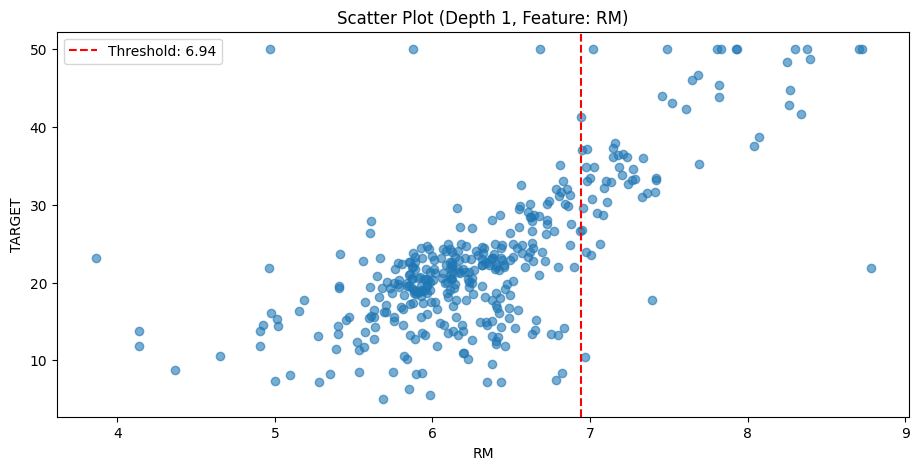

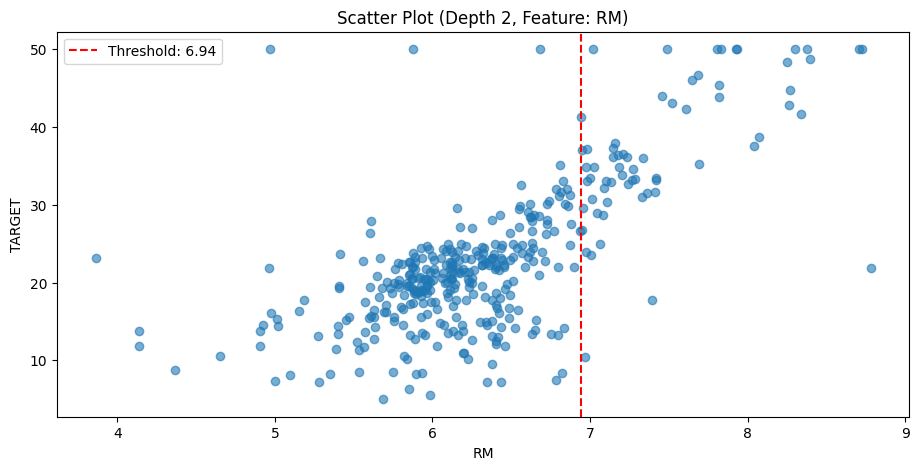

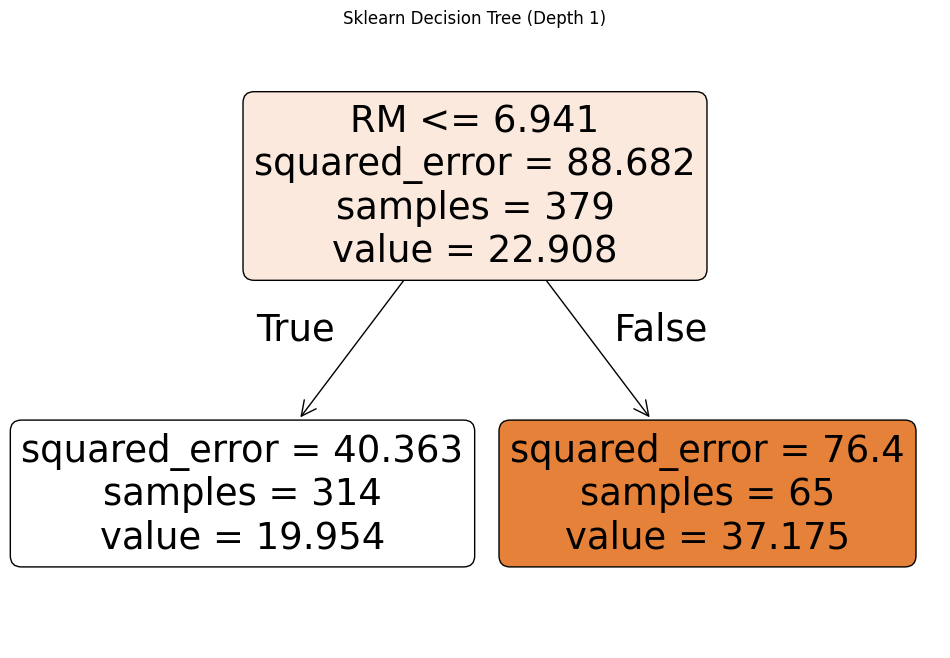

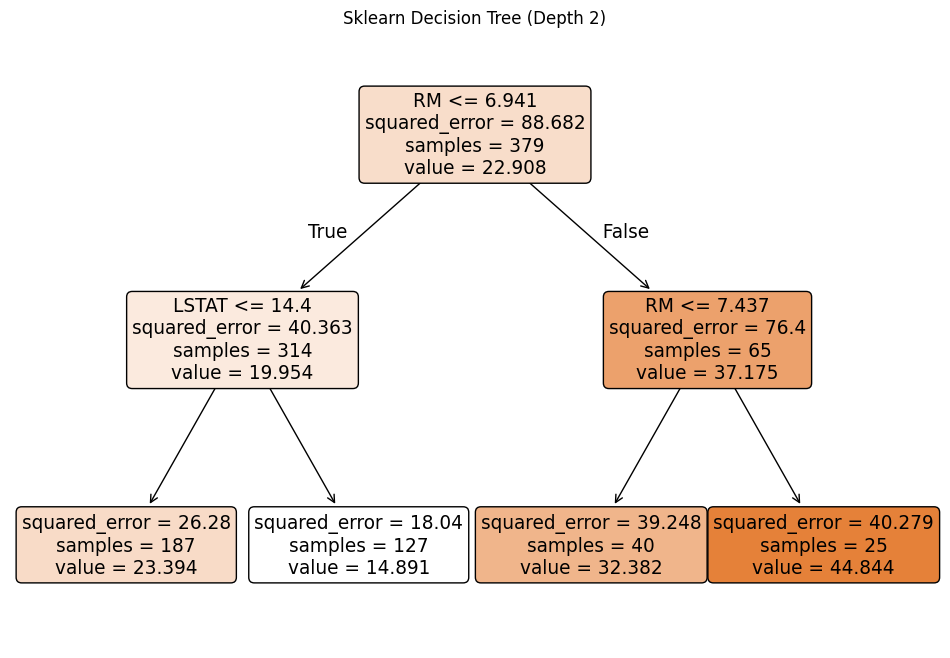

Depth 1 - Train MAE: 5.09, Test MAE: 4.87
Depth 2 - Train MAE: 3.54, Test MAE: 3.66
The tree with depth 2 does not show significant overfitting.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, plot_tree


X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Split the data into train (75%) and test (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit Decision Tree models with max_depth=1 and max_depth=2
tree_depth_1 = DecisionTreeRegressor(max_depth=1, random_state=42)
tree_depth_1.fit(X_train, y_train)

tree_depth_2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_depth_2.fit(X_train, y_train)


def plot_tree_splits(tree_model, depth, X_train, y_train, feature_names):

    feature_idx = tree_model.tree_.feature[0]
    threshold = tree_model.tree_.threshold[0]

    feature_name = feature_names[feature_idx]
    plt.scatter(X_train.iloc[:, feature_idx], y_train, alpha=0.6)
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.2f}')
    plt.xlabel(feature_name)
    plt.ylabel('TARGET')
    plt.title(f'Scatter Plot (Depth {depth}, Feature: {feature_name})')
    plt.legend()
    plt.show()

# Plot scatter for depth 1
plot_tree_splits(tree_depth_1, 1, X_train, y_train, X.columns)

# Plot scatter for depth 2
plot_tree_splits(tree_depth_2, 2, X_train, y_train, X.columns)

def visualize_sklearn_tree(tree_model, depth):
    plt.figure(figsize=(12, 8))
    plot_tree(tree_model, feature_names=X.columns, filled=True, rounded=True)
    plt.title(f'Sklearn Decision Tree (Depth {depth})')
    plt.show()

visualize_sklearn_tree(tree_depth_1, 1)
visualize_sklearn_tree(tree_depth_2, 2)

# Compare MAE on train and test
train_mae_1 = mean_absolute_error(y_train, tree_depth_1.predict(X_train))
test_mae_1 = mean_absolute_error(y_test, tree_depth_1.predict(X_test))

train_mae_2 = mean_absolute_error(y_train, tree_depth_2.predict(X_train))
test_mae_2 = mean_absolute_error(y_test, tree_depth_2.predict(X_test))

print(f"Depth 1 - Train MAE: {train_mae_1:.2f}, Test MAE: {test_mae_1:.2f}")
print(f"Depth 2 - Train MAE: {train_mae_2:.2f}, Test MAE: {test_mae_2:.2f}")

# Check for overfitting
if train_mae_2 < train_mae_1 and test_mae_2 > test_mae_1:
    print("The tree with depth 2 is likely overfitting.")
else:
    print("The tree with depth 2 does not show significant overfitting.")


### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset.
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset.
- Report `MAE` on test dataset and hyperparameters of the best estimator.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor


param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}


dt = DecisionTreeRegressor(random_state=42)

# GridSearchCV with 5-Fold Cross-Validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Extract the best hyperparameters and model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_


best_model.fit(X_train, y_train)


y_test_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)


print(f"Best Hyperparameters: {best_params}")
print(f"Test MAE: {test_mae:.2f}")


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Hyperparameters: {'max_depth': 6, 'min_samples_leaf': 2}
Test MAE: 2.46


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized.

In [ ]:
import numpy as np

def get_bias_variance(estimator, x, y, n_iter):
    """
    Calculate bias and variance of the `estimator`.
    Using a given dataset and bootstrap with `n_iter` samples.

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples,)
        The target values.
    n_iter: int
        Number of bootstrap iterations.

    Returns
    -------
    bias2 : float
        Estimated squared bias
    variance : float
        Estimated variance
    """
    n_samples = x.shape[0]
    predictions = np.zeros((n_iter, n_samples))

    for i in range(n_iter):

        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        oob_indices = np.setdiff1d(np.arange(n_samples), bootstrap_indices)


        x_bootstrap = x[bootstrap_indices]
        y_bootstrap = y[bootstrap_indices]
        estimator.fit(x_bootstrap, y_bootstrap)

        # Predict on OOB samples
        if len(oob_indices) > 0:
            predictions[i, oob_indices] = estimator.predict(x[oob_indices])
        else:
            predictions[i, :] = 0  # Fill with 0 if no OOB samples exist (edge case)

    # bias^2 and variance for each data point
    oob_mask = (predictions != 0)  # Mask to identify OOB predictions for each sample
    oob_counts = oob_mask.sum(axis=0)

    avg_predictions = np.sum(predictions, axis=0) / np.maximum(oob_counts, 1)  # Avoids division by zero
    variance_per_point = np.var(predictions, axis=0, ddof=1)
    bias2_per_point = (y - avg_predictions) ** 2

    # Average over all data points
    bias2 = np.mean(bias2_per_point[oob_counts > 0])
    variance = np.mean(variance_per_point[oob_counts > 0])

    return bias2, variance

# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)
bias2, variance = get_bias_variance(estimator, X_train.values, y_train.values, 10)

print(f"Estimated Bias^2: {bias2:.4f}")
print(f"Estimated Variance: {variance:.4f}")


Streaming output truncated to the last 5000 lines.
 26.6 25.  23.9 26.7 36.1 27.5 26.6 31.1 26.6 33.1]
Impurity (H) for y=[37.  33.8 34.6 30.5 32.  29.  31.  36.  35.1 31.1 35.1 30.1 50.  31.
 32.7 30.5 31.1 32.7 33.8 48.8]: 3.6535
Impurity (H) for y=[27.5 38.7 36.1 26.7 26.6 37.2 31.7 50.  28.  34.9 23.9 21.9 31.5 33.4
 23.9 22.  26.6 33.1 31.2 32.9 36.1 28.  31.7 31.7 23.9 34.9 26.6 26.6
 25.  23.9 26.7 36.1 27.5 26.6 26.6 33.1]: 4.609876543209877
Cost (Q) for feature 10, threshold 15.850000000000001: 4.268313492063493, Left: [37.  33.8 34.6 30.5 32.  29.  31.  36.  35.1 31.1 35.1 30.1 50.  31.
 32.7 30.5 31.1 32.7 33.8 48.8], Right: [27.5 38.7 36.1 26.7 26.6 37.2 31.7 50.  28.  34.9 23.9 21.9 31.5 33.4
 23.9 22.  26.6 33.1 31.2 32.9 36.1 28.  31.7 31.7 23.9 34.9 26.6 26.6
 25.  23.9 26.7 36.1 27.5 26.6 26.6 33.1]
Impurity (H) for y=[37.  33.8 34.6 30.5 32.  29.  31.  36.  35.1 31.1 35.1 30.1 50.  31.
 32.7 30.5 31.1 32.7 33.8 48.8 33.1]: 3.517460317460318
Impurity (H) for y=[27.5 38

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases.

Comment on what you observe, how does your result correspond to theory?

Streaming output truncated to the last 5000 lines.
Impurity (H) for y=[15.  16.3 14.1 17.3 15.  14.1 14.4 13.5 15.7 13.2 13.6 13.8  8.1 13.3
 14.5 17.3 14.4 13.5 15.  21.7]: 1.578
Impurity (H) for y=[ 7.2 10.5 13.1  6.3 10.2  8.5  7.2  6.3  7.5 15.4  8.5 10.5 13.9  8.3
  8.3 14.6  7.5  9.5 13.3 11.5  6.3 11.  13.3  8.3 13.3  7.2  8.4  6.3
  7.2 11.8  8.5 13.4  8.3  8.4 12.1  9.5  8.3 10.5 14.6]: 2.321367521367521
Cost (Q) for feature 4, threshold 0.6695: 2.069378531073446, Left: [15.  16.3 14.1 17.3 15.  14.1 14.4 13.5 15.7 13.2 13.6 13.8  8.1 13.3
 14.5 17.3 14.4 13.5 15.  21.7], Right: [ 7.2 10.5 13.1  6.3 10.2  8.5  7.2  6.3  7.5 15.4  8.5 10.5 13.9  8.3
  8.3 14.6  7.5  9.5 13.3 11.5  6.3 11.  13.3  8.3 13.3  7.2  8.4  6.3
  7.2 11.8  8.5 13.4  8.3  8.4 12.1  9.5  8.3 10.5 14.6]
Impurity (H) for y=[15.  16.3 13.1 14.1 10.2 13.9 17.3 13.3 15.  14.1 13.3 14.4 13.5 13.3
 15.7 13.2 13.6 13.8  8.1 13.3 14.5 17.3 14.4 13.5 15.  21.7]: 1.5139053254437873
Impurity (H) for y=[ 7.2 10.5  6.3

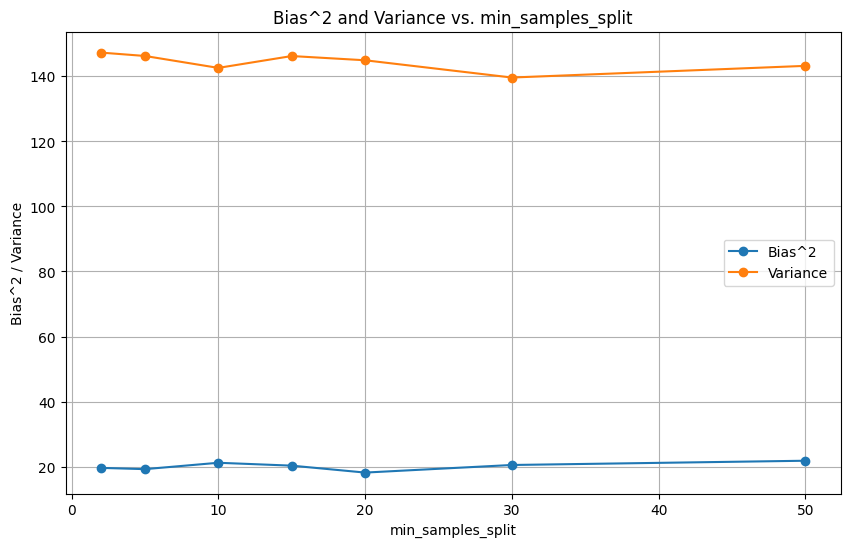

min_samples_split = 2: Bias^2 = 19.6324, Variance = 147.2654
min_samples_split = 5: Bias^2 = 19.2437, Variance = 146.2257
min_samples_split = 10: Bias^2 = 21.2020, Variance = 142.5593
min_samples_split = 15: Bias^2 = 20.3177, Variance = 146.2012
min_samples_split = 20: Bias^2 = 18.1858, Variance = 144.9027
min_samples_split = 30: Bias^2 = 20.5187, Variance = 139.5941
min_samples_split = 50: Bias^2 = 21.8277, Variance = 143.1843


In [ ]:
import matplotlib.pyplot as plt

# range of min_samples_split values
min_samples_split_values = [2, 5, 10, 15, 20, 30, 50]

# Store bias^2 and variance for each value
bias2_values = []
variance_values = []

#  bias and variance for each min_samples_split value
for min_samples_split in min_samples_split_values:
    estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=min_samples_split)
    bias2, variance = get_bias_variance(estimator, X_train.values, y_train.values, n_iter=10)
    bias2_values.append(bias2)
    variance_values.append(variance)


plt.figure(figsize=(10, 6))

plt.plot(min_samples_split_values, bias2_values, marker='o', label='Bias^2')
plt.plot(min_samples_split_values, variance_values, marker='o', label='Variance')

plt.xlabel('min_samples_split')
plt.ylabel('Bias^2 / Variance')
plt.title('Bias^2 and Variance vs. min_samples_split')
plt.legend()
plt.grid()
plt.show()


for i, min_split in enumerate(min_samples_split_values):
    print(f"min_samples_split = {min_split}: Bias^2 = {bias2_values[i]:.4f}, Variance = {variance_values[i]:.4f}")

### Main Answers to Task 7 Questions:

1. **What do you observe?**
   - **Bias²** remains relatively stable across the range of `min_samples_split`.
   - **Variance** decreases slightly as `min_samples_split` increases, with minor fluctuations.

2. **How does your result correspond to theory?**
   - The results go along with the **bias-variance tradeoff**:
     - Smaller `min_samples_split` values lead to a more flexible tree with lower bias² but higher variance.
     - Larger `min_samples_split` values create a less flexible tree with slightly higher bias² and lower variance.


### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance.

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments?
 - Do your results align with the theory? Why?

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd

# Bias-variance function for Scikit-Learn models
def get_bias_variance_sklearn(estimator, X, y, n_iter=10):
    n_samples = X.shape[0]
    predictions = np.zeros((n_iter, n_samples))

    for i in range(n_iter):
        # bootstrap indices and OOB indices
        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        oob_indices = np.setdiff1d(np.arange(n_samples), bootstrap_indices)


        X_bootstrap = X[bootstrap_indices]
        y_bootstrap = y[bootstrap_indices]
        estimator.fit(X_bootstrap, y_bootstrap)


        if len(oob_indices) > 0:
            predictions[i, oob_indices] = estimator.predict(X[oob_indices])


    oob_mask = (predictions != 0)
    oob_counts = oob_mask.sum(axis=0)

    avg_predictions = np.sum(predictions, axis=0) / np.maximum(oob_counts, 1)
    variance_per_point = np.var(predictions, axis=0, ddof=1)
    bias2_per_point = (y - avg_predictions) ** 2

    bias2 = np.mean(bias2_per_point[oob_counts > 0])
    variance = np.mean(variance_per_point[oob_counts > 0])
    return bias2, variance

#  BaggingRegressor
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=8, min_samples_split=15),
    n_estimators=50,
    random_state=42
)

# Convert data to NumPy arrays
X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train


bias2_bagging, variance_bagging = get_bias_variance_sklearn(bagging_model, X_train_np, y_train_np, n_iter=10)


print(f"Bagging Model - Bias^2: {bias2_bagging:.4f}, Variance: {variance_bagging:.4f}")


Bagging Model - Bias^2: 14.3101, Variance: 139.2823


### Main Answers to Task 8 Questions:

1. **How should bagging affect bias and variance in theory?**
   - Bagging typically reduces **variance** by averaging predictions from multiple models trained on bootstrap samples.
   - It generally does not significantly reduce **bias**, as the individual model's bias is retained.

2. **How did bias and variance change compared to an individual tree in your experiments?**
   - Compared to the individual decision tree (from Task 6):
     - **Bias²** decreased from approximately 20.21 to 14.31, showing improvement in prediction accuracy.
     - **Variance** slightly decreased from 140.42 to 139.28, indicating reduced variability in predictions.

3. **Do your results align with the theory? Why?**
   - Yes, the results align with the theory:
     - Bagging effectively reduced **variance** due to ensemble averaging.
     - It also reduced **bias²**, likely due to the combination of multiple tree predictions, which smooths out inaccuracies from any single tree.

# Part 2. More Ensembles

In this part we will be working with [Billionaires Statistics Dataset](https://www.kaggle.com/datasets/nelgiriyewithana/billionaires-statistics-dataset) to solve a classification task.

### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing.

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice.
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are more than 10 unique values in a column, use `min_frequency` and/or `max_categories` parameter)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer.
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values.

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset.

In [2]:
df = pd.read_csv('Billionaires Statistics Dataset.csv')
df.head()

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,...,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,67059887.0,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Motivate :
# - 'personName' is irrelevant for classification as it's a unique identifier
# - Other columns like 'latitude_country', 'longitude_country', etc., are redundant or contain too many missing values
columns_to_drop = [
    'personName', 'latitude_country', 'longitude_country', 'city',
    'source', 'industries', 'country', 'countryOfCitizenship'
]
df = df.drop(columns=columns_to_drop)


y = df['selfMade'].fillna('Unknown')
X = df.drop('selfMade', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Separate categorical and numeric columns
categorical_columns = X_train.select_dtypes(include=['object']).columns
numeric_columns = X_train.select_dtypes(include=['number']).columns


# For categorical columns: Fill missing values with the most frequent value and one-hot encode
# max_categories or min_frequency for large cardinality
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', max_categories=10)
)

# For numeric columns: Fill missing values with the mean and scale the features
numeric_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

# Combine into a single ColumnTransformer
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, categorical_columns),
        ('num', numeric_pipeline, numeric_columns)
    ],
    remainder='drop'
)


X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)


print(f"Transformed X_train shape: {X_train.shape}")
print(f"Transformed X_test shape: {X_test.shape}")


Transformed X_train shape: (1980, 109)
Transformed X_test shape: (660, 109)


### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

Gradient Boosting - Mean F1 Score: 0.7759, Std: 0.0255
Random Forest - Mean F1 Score: 0.7881, Std: 0.0153
Decision Tree - Mean F1 Score: 0.7365, Std: 0.0191
SVM - Mean F1 Score: 0.7698, Std: 0.0181
Logistic Regression - Mean F1 Score: 0.7742, Std: 0.0180


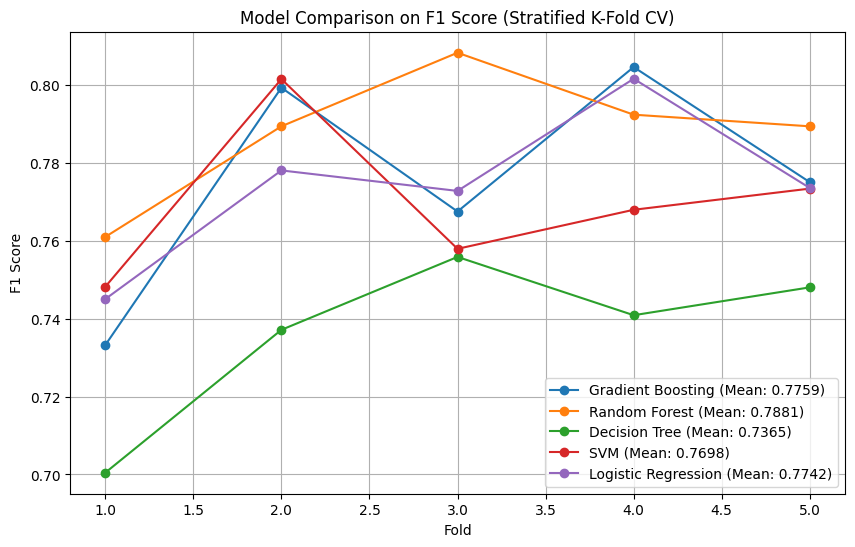

In [4]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score

# the models
models = {
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=500)
}

# the F1 score as the evaluation metric
# Justification: The F1 score is appropriate for imbalanced datasets as it balances precision and recall.
scorer = make_scorer(f1_score, average='weighted')

# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


model_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scorer, n_jobs=-1)
    model_scores[name] = scores
    print(f"{name} - Mean F1 Score: {scores.mean():.4f}, Std: {scores.std():.4f}")

# Compare
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
for name, scores in model_scores.items():
    plt.plot(range(1, cv.n_splits + 1), scores, marker='o', label=f"{name} (Mean: {scores.mean():.4f})")

plt.title('Model Comparison on F1 Score (Stratified K-Fold CV)')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()


### Answers to Questions:

1. **Which model has the best performance?**
   - **Random Forest** achieved the best performance with the highest mean F1 Score (**0.7881**) and low variance.

2. **Which models overfit or underfit?**
   - **Decision Tree**  underfits the data due to its simplicity and lack of ensemble boosting.
   - Other models, including **Random Forest** and **Gradient Boosting**, show no signs of overfitting or underfitting.

3. **Justification for the chosen metric (F1 Score):**
   - The F1 Score balances precision and recall, making it suitable for imbalanced datasets. It provides a more holistic evaluation compared to accuracy.

4. **Does the result align with the theory?**
   - Yes, ensemble methods like **Random Forest** and **Gradient Boosting** outperform simpler models (e.g., Decision Tree) as they effectively reduce variance and capture complex relationships in the data. :)

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to take one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task.

In [5]:
!pip install xgboost

In [6]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer


xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')


param_grid = {
    'n_estimators': [50, 100, 200],      # Number of trees
    'learning_rate': [0.01, 0.1, 0.3],  # Learning rate
    'max_depth': [3, 5, 7]              # Tree depth
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average='weighted')


grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    verbose=1,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)


best_xgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_


y_test_pred = best_xgb_model.predict(X_test)
test_f1_score = f1_score(y_test, y_test_pred, average='weighted')


print("Best Hyperparameters:", best_params)
print(f"Test F1 Score: {test_f1_score:.4f}")

# Compare with models from Task 2
print("\nComparison with Previous Models:")
print(f"Gradient Boosting (XGBoost) - Test F1 Score: {test_f1_score:.4f}")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{name} - Test F1 Score: {f1:.4f}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:33:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Test F1 Score: 0.7693

Comparison with Previous Models:
Gradient Boosting (XGBoost) - Test F1 Score: 0.7693
Gradient Boosting - Test F1 Score: 0.7105
Random Forest - Test F1 Score: 0.7721
Decision Tree - Test F1 Score: 0.7206
SVM - Test F1 Score: 0.7723
Logistic Regression - Test F1 Score: 0.7539


### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees?
* What is the difference between voting and staking?

Bagging (Decision Tree) - Test F1 Score: 0.7541
Bagging (Gradient Boosting) - Test F1 Score: 0.7547
Voting Classifier - Test F1 Score: 0.7787
Stacking (Logistic Regression) - Test F1 Score: 0.7609
Stacking (Gradient Boosting) - Test F1 Score: 0.7712


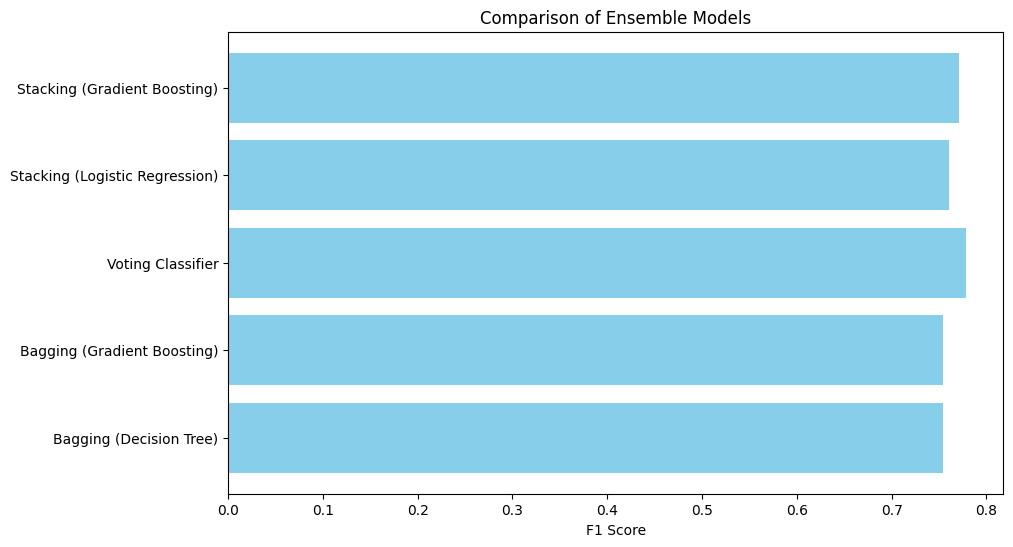

In [7]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


bagging_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=50,
    random_state=42
)


bagging_gb = BaggingClassifier(
    estimator=GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
    ),
    n_estimators=10,
    random_state=42
)

# Voting Classifier (Hard voting)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=500, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    voting='hard'
)

# Stacking Classifier with Logistic Regression as the final model
stacking_lr = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=500, random_state=42)
)

# Stacking Classifier with Gradient Boosting as the final model
stacking_gb = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('svc', SVC(probability=True, random_state=42)),
        ('dt', DecisionTreeClassifier(max_depth=5, random_state=42))
    ],
    final_estimator=GradientBoostingClassifier(n_estimators=100, random_state=42)
)


models = {
    'Bagging (Decision Tree)': bagging_dt,
    'Bagging (Gradient Boosting)': bagging_gb,
    'Voting Classifier': voting_clf,
    'Stacking (Logistic Regression)': stacking_lr,
    'Stacking (Gradient Boosting)': stacking_gb
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = f1
    print(f"{name} - Test F1 Score: {f1:.4f}")


plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), list(results.values()), color='skyblue')
plt.xlabel('F1 Score')
plt.title('Comparison of Ensemble Models')
plt.show()


1. **Best Performing Model**: Voting Classifier (**F1 Score: 0.7787**).

2. **Does Bagging Reduce Overfitting for Gradient Boosting?**: Bagging littlr reduced overfitting but did not outperform other ensemble methods significantly.

3. **Difference Between Voting and Stacking**:
   - **Voting**: Combines predictions directly (majority or average).
   - **Stacking**: Uses a meta-model to learn from base model predictions.

4. **Main Conclusion**: Voting Classifier performed the best, but Stacking also showed strong results with slightly lower scores. Bagging was competitive but not the top performer.

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train.

In [8]:

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Re-fit the best model (Voting Classifier)
best_model = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=500, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    voting='hard'
)
best_model.fit(X_train, y_train)


y_test_pred = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_accuracy = accuracy_score(y_test, y_test_pred)


print(f"Best Model: Voting Classifier")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Best Model: Voting Classifier
Test F1 Score: 0.7787
Test Accuracy: 0.7909

Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.51      0.61       207
        True       0.80      0.92      0.86       453

    accuracy                           0.79       660
   macro avg       0.77      0.72      0.73       660
weighted avg       0.78      0.79      0.78       660

